In [ ]:
#Step 1: Setting up the environment
!pip install transformers tensorflow keras pandas matplotlib seaborn numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# For LSTM model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# For BERT model
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf

In [ ]:
# Load the IMDB dataset from CSV (you can download from Kaggle)
# https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
df = pd.read_csv('IMDB Dataset.csv')

# Explore the data
print(df.head())
print(df['sentiment'].value_counts())

# Convert sentiment to numerical (1 for positive, 0 for negative)
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split data into train and test (80-20 split)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['label'], test_size=0.2, random_state=42)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [ ]:
## Step 2: Implementing LSTM

# Tokenization and padding for LSTM
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_padded = pad_sequences(train_sequences, maxlen=max_len)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, 128))
lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train LSTM model
lstm_history = lstm_model.fit(
    train_padded, train_labels,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

# Evaluate LSTM
lstm_preds = (lstm_model.predict(test_padded) > 0.5).astype("int32")
lstm_accuracy = accuracy_score(test_labels, lstm_preds)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")
print(classification_report(test_labels, lstm_preds))

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 429s 414ms/step - accuracy: 0.7337 - loss: 0.5249 - val_accuracy: 0.8111 - val_loss: 0.4247
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 406s 386ms/step - accuracy: 0.8523 - loss: 0.3596 - val_accuracy: 0.8309 - val_loss: 0.4195
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 446s 390ms/step - accuracy: 0.8765 - loss: 0.3054 - val_accuracy: 0.8711 - val_loss: 0.3193
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 433s 382ms/step - accuracy: 0.9130 - loss: 0.2293 - val_accuracy: 0.8714 - val_loss: 0.3116
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 383s 383ms/step - accuracy: 0.9334 - loss: 0.1848 - val_accuracy: 0.8754 - val_loss: 0.3270
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step
LSTM Accuracy: 0.8790
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     100

In [ ]:
## Step 3: Implementing BERT

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(1000).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

# Load BERT model for sequence classification
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define optimizer with HuggingFace helper
num_train_steps = len(train_dataset) * 3  # 3 epochs
optimizer, _ = create_optimizer(
    init_lr=3e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

# Compile model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train model
bert_history = bert_model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset
)

# Evaluate
bert_logits = bert_model.predict(test_dataset).logits
bert_preds = tf.argmax(bert_logits, axis=1).numpy()

# Calculate metrics
print(f"\nBERT Accuracy: {accuracy_score(test_labels, bert_preds):.4f}")
print("\nClassification Report:\n", classification_report(test_labels, bert_preds))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
2500/2500 [==============================] - 1262s 490ms/step - loss: 0.3052 - accuracy: 0.8672 - val_loss: 0.2596 - val_accuracy: 0.8890
Epoch 2/3
2500/2500 [==============================] - 1176s 470ms/step - loss: 0.1506 - accuracy: 0.9430 - val_loss: 0.3061 - val_accuracy: 0.8946
Epoch 3/3
625/625 [==============================] - 96s 149ms/step

BERT Accuracy: 0.9002

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



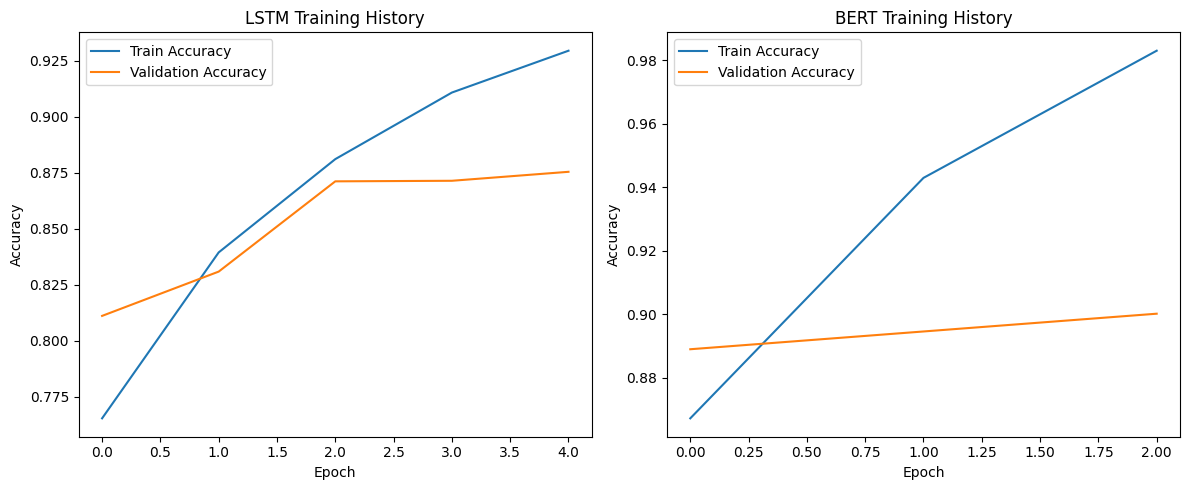

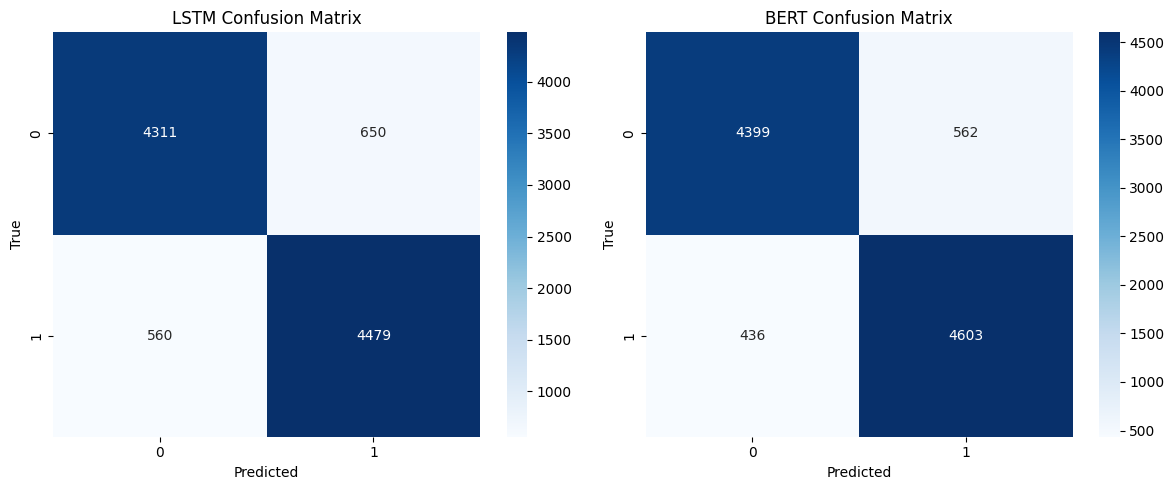

NameError: name 'bert_accuracy' is not defined

In [ ]:
## Visualizations

# Plot training history for both models
plt.figure(figsize=(12, 5))

# LSTM Accuracy
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# BERT Accuracy
plt.subplot(1, 2, 2)
plt.plot(bert_history.history['accuracy'], label='Train Accuracy')
plt.plot(bert_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('BERT Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrices
plt.figure(figsize=(12, 5))

# LSTM Confusion Matrix
plt.subplot(1, 2, 1)
cm_lstm = confusion_matrix(test_labels, lstm_preds)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# BERT Confusion Matrix
plt.subplot(1, 2, 2)
cm_bert = confusion_matrix(test_labels, bert_preds)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues')
plt.title('BERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Final comparison
models = ['LSTM', 'BERT']
accuracies = [lstm_accuracy, bert_accuracy]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()

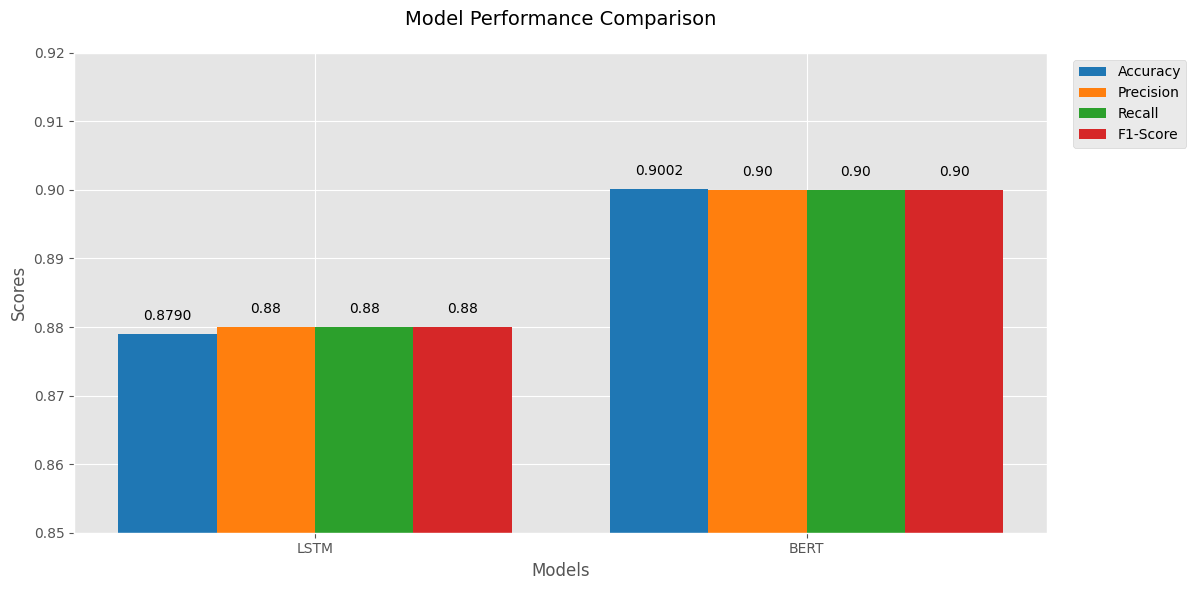

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your classification reports
models = ['LSTM', 'BERT']
accuracy = [0.8790, 0.9002]
precision = [0.88, 0.90]  # Weighted avg
recall = [0.88, 0.90]     # Weighted avg
f1 = [0.88, 0.90]         # Weighted avg

# Set up the figure
plt.figure(figsize=(12, 6))

# Bar width
bar_width = 0.2
x = np.arange(len(models))

# Create bars
plt.bar(x - bar_width, accuracy, width=bar_width, label='Accuracy', color='#1f77b4')
plt.bar(x, precision, width=bar_width, label='Precision', color='#ff7f0e')
plt.bar(x + bar_width, recall, width=bar_width, label='Recall', color='#2ca02c')
plt.bar(x + 2*bar_width, f1, width=bar_width, label='F1-Score', color='#d62728')

# Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, pad=20)
plt.xticks(x + bar_width/2, models)
plt.ylim(0.85, 0.92)  # Adjusted to show differences clearly

# Add value labels on top of bars
for i in range(len(models)):
    plt.text(x[i] - bar_width, accuracy[i] + 0.002, f'{accuracy[i]:.4f}', ha='center')
    plt.text(x[i], precision[i] + 0.002, f'{precision[i]:.2f}', ha='center')
    plt.text(x[i] + bar_width, recall[i] + 0.002, f'{recall[i]:.2f}', ha='center')
    plt.text(x[i] + 2*bar_width, f1[i] + 0.002, f'{f1[i]:.2f}', ha='center')

# Add legend and adjust layout
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()